In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from ast import literal_eval
import torch
import re
import pandarallel
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import umap

pandarallel.pandarallel.initialize(progress_bar=True, nb_workers=10)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()
# scaled_penguin_data = sklearn.preprocessing.StandardScaler().fit_transform(penguin_data)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [10]:
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values

In [15]:
penguin_data

array([[  39.1,   18.7,  181. , 3750. ],
       [  39.5,   17.4,  186. , 3800. ],
       [  40.3,   18. ,  195. , 3250. ],
       ...,
       [  49.6,   18.2,  193. , 3775. ],
       [  50.8,   19. ,  210. , 4100. ],
       [  50.2,   18.7,  198. , 3775. ]])

In [2]:
pattern = r",\s*dtype=float32\)\]"

def process_output(x):
    x = x.replace("],\n      dtype=float32)", "")
    x = x.replace("\n", "")
    x = x.replace("\t", "")
    x = x.replace("array([", "")
    x = x.replace("],dtype=float32)", "")
    x = re.sub(pattern, "", x)
    return literal_eval(x)

def get_tile_coordinates(filename):
    coords = filename.split(".")[0]
    coords = coords.split("_")
    x = int(coords[1])
    y = int(coords[2])
    return x,y

In [3]:
sample_data = pd.read_csv("../output/Image_A-22-00025A4-1_embeddings.csv")

In [4]:
sample_data["tile_coordinates"] = sample_data["filename"].parallel_apply(lambda x: get_tile_coordinates(x))
sample_data["output"] = sample_data["output"].parallel_apply(lambda x: process_output(x))

In [5]:
sample_data["output"] = sample_data["output"].parallel_apply(lambda x: np.array(x))

In [16]:
umap_array = np.stack(sample_data["output"].values)

In [24]:
umap_array_scaled = sklearn.preprocessing.StandardScaler().fit_transform(umap_array)
reducer = umap.UMAP()
embdedding = umap.UMAP(    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,).fit_transform(umap_array_scaled)

/home/prajitrr/miniconda3/envs/heart-histology-pipeline/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/prajitrr/miniconda3/envs/heart-histology-pipeline/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


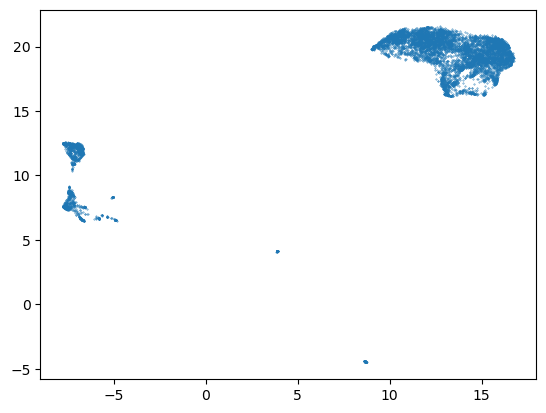

In [27]:
plt.scatter(embdedding[:, 0], embdedding[:, 1], s=0.1)

In [6]:
pca_list = sample_data["output"].to_list()

In [101]:
pca = sklearn.decomposition.PCA(n_components=1536)
reduced = pca.fit_transform(pca_list)

In [102]:
x_coord = [x[0] for x in sample_data["tile_coordinates"].to_list()]
y_coord = [x[1] for x in sample_data["tile_coordinates"].to_list()]

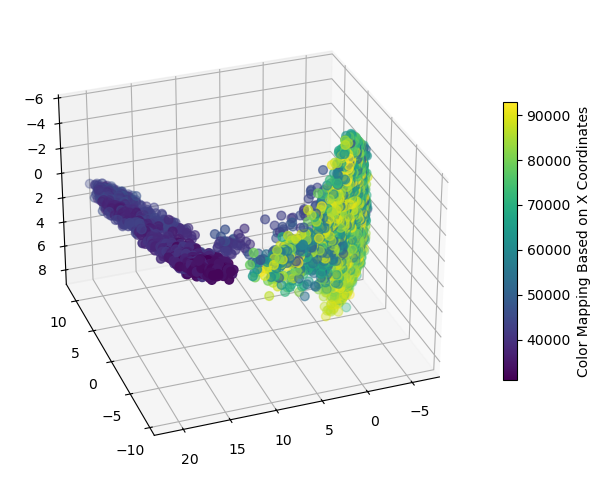

In [10]:
x_norm = Normalize(vmin=np.min(x_coord), vmax=np.max(x_coord))
x_colors = cm.viridis(x_norm(x_coord))
y_norm = Normalize(vmin=np.min(y_coord), vmax=np.max(y_coord))
y_colors = cm.viridis(y_norm(y_coord))

fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
scatter = ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=x_colors, s=40)
cbar = plt.colorbar(cm.ScalarMappable(norm=x_norm, cmap='viridis'), ax=ax, shrink=0.6)
cbar.set_label('Color Mapping Based on X Coordinates')

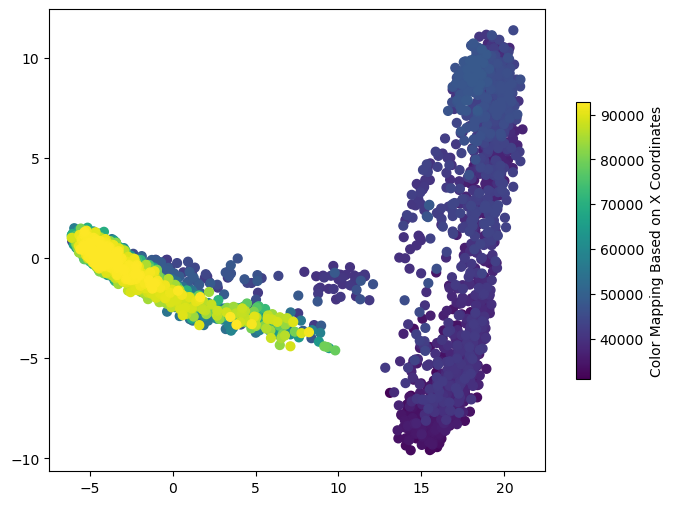

In [103]:

fig_2 = plt.figure(1, figsize=(8,6))
ax_2 = fig_2.add_subplot()
scatter = ax_2.scatter(reduced[:, 0], reduced[:, 1], c=x_colors, s=40)
cbar = plt.colorbar(cm.ScalarMappable(norm=x_norm, cmap='viridis'), ax=ax_2, shrink=0.6)
cbar.set_label('Color Mapping Based on X Coordinates')

In [ ]:
x_norm = Normalize(vmin=np.min(x_coord), vmax=np.max(x_coord))
x_colors = cm.viridis(x_norm(x_coord))
y_norm = Normalize(vmin=np.min(y_coord), vmax=np.max(y_coord))
y_colors = cm.viridis(y_norm(y_coord))

fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
scatter = ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=x_colors, s=40)
cbar = plt.colorbar(cm.ScalarMappable(norm=x_norm, cmap='viridis'), ax=ax, shrink=0.6)
cbar.set_label('Color Mapping Based on X Coordinates')

Now replot after filtering out edge tiles

In [104]:
reduced_x_edge_mask = reduced[:, 0] < 10
x_coord_1 = np.array(x_coord)[reduced_x_edge_mask]
y_coord_1 = np.array(y_coord)[reduced_x_edge_mask]
pca_list_1 = np.array(pca_list)[reduced_x_edge_mask]
reduced_1 = pca.fit_transform(pca_list_1)



In [12]:
x_norm_1 = Normalize(vmin=np.min(x_coord_1), vmax=np.max(x_coord_1))
x_colors_1 = cm.viridis(x_norm(x_coord_1))
y_norm_1 = Normalize(vmin=np.min(y_coord_1), vmax=np.max(y_coord_1))
y_colors_1 = cm.viridis(y_norm(y_coord_1))

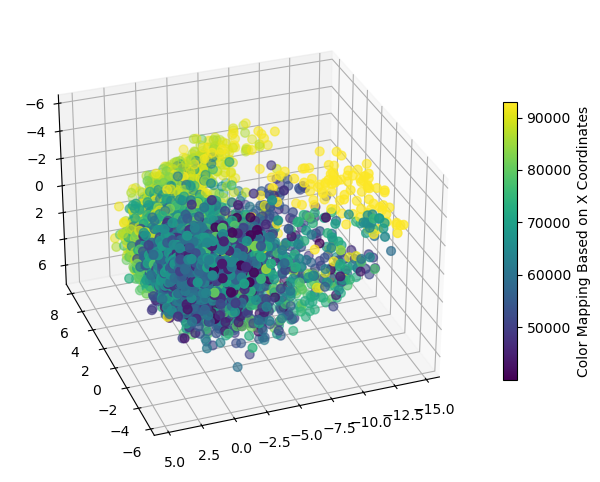

In [13]:
fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

scatter = ax.scatter(reduced_1[:, 0], reduced_1[:, 1], reduced_1[:, 2], c=y_colors_1, s=40)
cbar = plt.colorbar(cm.ScalarMappable(norm=x_norm_1, cmap='viridis'), ax=ax, shrink=0.6)
cbar.set_label('Color Mapping Based on X Coordinates')

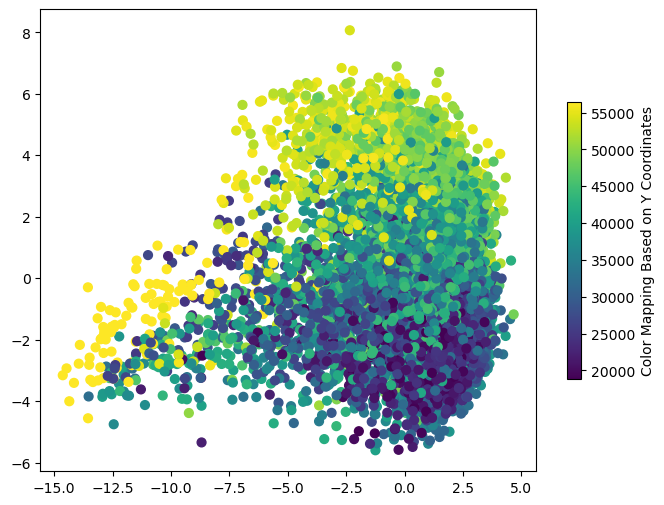

In [14]:
fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot()

scatter = ax.scatter(reduced_1[:, 0], reduced_1[:, 1], c=y_colors_1, s=40)
cbar = plt.colorbar(cm.ScalarMappable(norm=y_norm_1, cmap='viridis'), ax=ax, shrink=0.6)
cbar.set_label('Color Mapping Based on Y Coordinates')

In [81]:
analysis_mask = (reduced_1[:, 0] < -10) & (reduced_1[:, 1] > -2)
x_coord_1[analysis_mask]

array([41810, 43602, 46738, 49874, 52114, 52562, 53458, 53458, 59282,
       59730, 60178, 61074, 62418, 63314, 65554, 66450, 67794, 68690,
       70034, 70034, 70930, 71378, 72274, 72722, 73170, 74962, 75858,
       76306, 77202, 77650, 80786, 81234, 81682, 82130, 82130, 82578,
       83026, 83474, 83474, 83922, 84818, 85714, 86162, 86610, 87058,
       87058, 87506, 87506, 87954, 88402, 88850, 89298, 90194])

In [82]:
y_coord_1[analysis_mask]

array([38565, 32293, 32741, 56485, 27813, 56485, 26917, 56485, 56485,
       56485, 56485, 56485, 56485, 56485, 56485, 56485, 56485, 56485,
       22885, 56485, 56485, 56485, 56485, 56485, 56485, 56485, 56485,
       56485, 56485, 56485, 56485, 56485, 56485, 54693, 56485, 56485,
       56485, 40805, 56485, 56485, 56485, 56485, 56485, 56485, 37669,
       56485, 53349, 56485, 56485, 56485, 56485, 56485, 56485])

In [24]:
len(kmeans.labels_)

9192

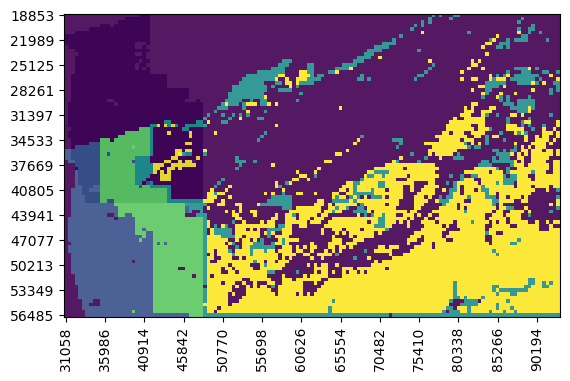

In [151]:
kmeans = sklearn.cluster.KMeans(n_clusters=5, random_state=0, n_init="auto").fit(pca_list)

x_unique = np.unique(x_coord)
y_unique = np.unique(y_coord)



# Create an empty grid for labels
label_grid = np.empty((len(y_unique), len(x_unique)))  # Shape (rows, cols)

# Fill the grid with labels based on x, y positions
for i in range(len(x_coord)):
    x_idx = np.where(x_unique == x_coord[i])
    y_idx = np.where(y_unique == y_coord[i])
    label_grid[y_idx, x_idx] = kmeans.labels_[i]


# Create and fill in another grid for PCA 

x_coords_pca = np.array(x_coord)[~reduced_x_edge_mask]
y_coords_pca = np.array(y_coord)[~reduced_x_edge_mask]
x_coords_pca_unique = np.unique(x_coords_pca)
y_coords_pca_unique = np.unique(y_coords_pca)
mask = np.zeros_like(label_grid, dtype=bool)
for i in range(len(x_coords_pca)):
    x_idx = np.where(x_coords_pca_unique == x_coords_pca[i])
    y_idx = np.where(y_coords_pca_unique == y_coords_pca[i])
    mask[y_idx, x_idx] = True

x_ticks = 12
x_step = max(1, label_grid.shape[1] // x_ticks)
y_ticks = 12
y_step = max(1, label_grid.shape[0] // y_ticks)
x_tick_positions = np.arange(0, label_grid.shape[1], x_step)
y_tick_positions = np.arange(0, label_grid.shape[0], y_step)

plt.xticks(x_tick_positions, x_unique[x_tick_positions])
plt.xticks(rotation=90)

plt.yticks(y_tick_positions, y_unique[y_tick_positions])



plt.imshow(label_grid, alpha=1 )
plt.imshow(mask, alpha=0.1, cmap="Blues")



TSNE

In [150]:
tsne_embedded = sklearn.manifold.TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(np.array(pca_list))


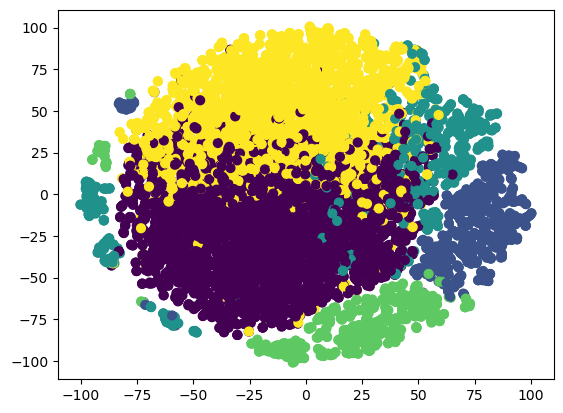

In [152]:
plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], c=kmeans.labels_, cmap="viridis", s=40)